In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

### <div class='exercise'> Data Pre-Processing and Baseline Modelling </div>
---

Naive Mean Model Score: 0.5
Baseline Logistic Regression Score: 0.7356105810651266


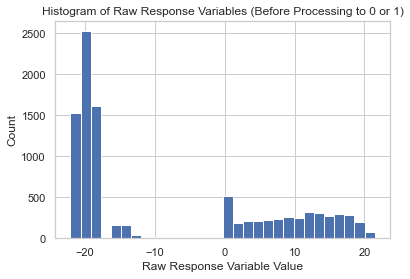

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

plt.hist(x=y_data.values, bins=30)
plt.xlabel("Raw Response Variable Value")
plt.ylabel("Count")
plt.title("Histogram of Raw Response Variables (Before Processing to 0 or 1)")

y_data['y'] = (abs(y_data['y'])>=18)*1

# Splitting data first
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    random_state = 109, shuffle=True, 
                                                    stratify=y_data['y'])

# Standardizing data to aid in model convergence and performance
scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train)
X_test_imputed = scaler.fit_transform(X_test)

# Imputing X_data with KNN imputer, n_neighbors = 1 to handle NaN values
imputer = KNNImputer(n_neighbors=1)
X_train_impute = imputer.fit_transform(X_train_imputed)
X_test_impute = imputer.fit_transform(X_test_imputed)

# Turning ndarray into DF; resetting column names
X_train_impute = pd.DataFrame(X_train_impute, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

# Resetting variable values to aid in interpretabiltiy 
X_train_impute['Sex'] = X_train_impute['Sex'].subtract(1)
X_test_impute['Sex'] = X_test_impute['Sex'].subtract(1)
X_train_impute['Race'] = X_train_impute['Race'].subtract(1)
X_test_impute['Race'] = X_test_impute['Race'].subtract(1)

# Baseline KNN model (n = DF size, so essentially mean) on imputed data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = roc_auc_score(y_test, y_pred)
print("Naive Mean Model Score:", baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=5000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = roc_auc_score(y_test, y_pred)
print("Baseline Logistic Regression Score:", logit_base_test_accuracy)

### <div class="exercise"> k-NN Performance </div>

In [3]:
k_list = [100,120,150,200,500]
validation_error = []
training_error = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_impute, y_train.values.ravel())
    
    accuracies = cross_validate(knn, X_train_impute, y_train.values.ravel(), scoring = "roc_auc", cv=5, return_train_score=True)

    # Compute the validation errors got after cross validation
    train_acc = accuracies['train_score'].mean()
    val_acc =  accuracies['test_score'].mean()
    
    # Append the Accuracies to their respective lists     
    validation_error.append(val_acc)
    training_error.append(train_acc)
    
    

In [4]:
max_val = max(validation_error)
k = k_list[validation_error.index(max_val)]
print(k)

200


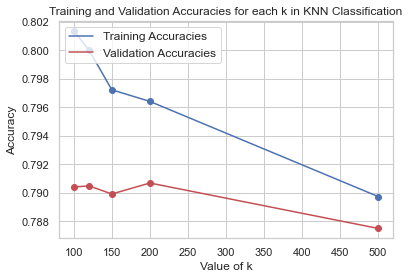

In [5]:
# scatter plot and line for training acc
plt.scatter(k_list,training_error, color="b")
plt.plot(k_list,training_error, color="b", label="Training Accuracies")

# scatter plot and line for val acc
plt.scatter(k_list,validation_error, color="r")
plt.plot(k_list,validation_error, color="r", label="Validation Accuracies")

# Labels, axes, and legend
plt.title("Training and Validation Accuracies for each k in KNN Classification")
plt.xlabel("Value of k")
plt.ylabel("Accuracy")
plt.legend(loc = 'upper left', fontsize = 12)

In [6]:
best_knn = KNeighborsClassifier(n_neighbors=k)
best_knn.fit(X_train_impute, y_train.values.ravel())

y_test_pred = best_knn.predict(X_test_impute)

best_knn_test_acccuracy = roc_auc_score(y_test, y_test_pred)

print("The overall test classification accuracy as a percentage is: ", round(best_knn_test_acccuracy,6))


The overall test classification accuracy as a percentage is:  0.679411


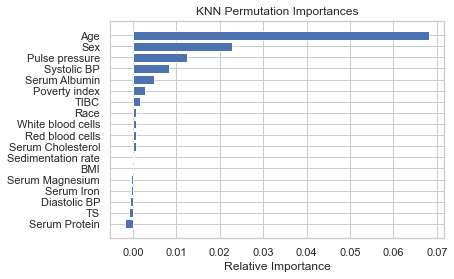

In [7]:
from sklearn.inspection import permutation_importance
features = X_train.columns
importances = permutation_importance(best_knn, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

plt.title("KNN Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Logistic Regression Lasso

In [8]:
standard_scaler = StandardScaler().fit(X_train_impute)

X_train_impute_standard = standard_scaler.transform(X_train_impute)
X_test_impute_standard = standard_scaler.transform(X_test_impute)

logit_lasso = LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga')

logit_lasso.fit(X_train_impute_standard, y_train.values.ravel())
    
y_pred_train = logit_lasso.predict(X_train_impute_standard)
    
y_pred_test = logit_lasso.predict(X_test_impute_standard)
    
logit_lasso_train_auc_score = roc_auc_score(y_train, y_pred_train)
logit_lasso_test_auc_score = roc_auc_score(y_test, y_pred_test)

print("Logistic regression lasso train AUC score: ")
print(logit_lasso_train_auc_score)
print("\nLogistic regression lasso test AUC score: ")
print(logit_lasso_test_auc_score)

print(f"The y-intercept for logistic regression lasso:\n{logit_lasso.intercept_[0]:.3f}\n")
for i in range(len(logit_lasso.coef_[0])):
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+" for logistic regression lasso:")
    print(str(logit_lasso.coef_[0][i])+"\n")

Logistic regression lasso train AUC score: 
0.735463421020664

Logistic regression lasso test AUC score: 
0.7351973579246307
The y-intercept for logistic regression lasso:
0.575

The beta coefficient 1 Age for logistic regression lasso:
-0.9179459801649618

The beta coefficient 2 Diastolic BP for logistic regression lasso:
0.0

The beta coefficient 3 Poverty index for logistic regression lasso:
0.16245068636196536

The beta coefficient 4 Race for logistic regression lasso:
-0.15427810031168637

The beta coefficient 5 Red blood cells for logistic regression lasso:
0.022348776593390268

The beta coefficient 6 Sedimentation rate for logistic regression lasso:
-0.12464398377711611

The beta coefficient 7 Serum Albumin for logistic regression lasso:
0.2785641224634092

The beta coefficient 8 Serum Cholesterol for logistic regression lasso:
0.020221378985115623

The beta coefficient 9 Serum Iron for logistic regression lasso:
-0.07010557892578702

The beta coefficient 10 Serum Magnesium for 

## CV Logistic Regression with Lasso

In [9]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_lasso_CV = LogisticRegressionCV(penalty = 'l1', scoring="roc_auc", Cs=Cs_vals, cv = 5, max_iter = 2000, solver ='liblinear')

logit_lasso_CV.fit(X_train_impute_standard, y_train.values.ravel())
    
y_pred_train_CV = logit_lasso_CV.predict(X_train_impute_standard)
    
y_pred_test_CV = logit_lasso_CV.predict(X_test_impute_standard)
    
logit_lasso_train_auc_score_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_lasso_test_auc_score_CV = roc_auc_score(y_test, y_pred_test_CV)

print("Logistic regression CV lasso train auc score: ")
print(logit_lasso_train_auc_score_CV)
print("\nLogistic regression CV lasso test auc score: ")
print(logit_lasso_test_auc_score_CV)

print(f"The y-intercept for logistic regression lasso CV:\n{logit_lasso_CV.intercept_[0]:.3f}\n")
for i in range(len(logit_lasso_CV.coef_[0])):
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+" for logistic regression lasso CV:")
    print(str(logit_lasso_CV.coef_[0][i])+"\n")

Logistic regression CV lasso train auc score: 
0.7362001324404095

Logistic regression CV lasso test auc score: 
0.734370911643639
The y-intercept for logistic regression lasso CV:
0.566

The beta coefficient 1 Age for logistic regression lasso CV:
-0.9037122573362801

The beta coefficient 2 Diastolic BP for logistic regression lasso CV:
0.0

The beta coefficient 3 Poverty index for logistic regression lasso CV:
0.15669060931434314

The beta coefficient 4 Race for logistic regression lasso CV:
-0.1499544313466743

The beta coefficient 5 Red blood cells for logistic regression lasso CV:
0.015186866635177283

The beta coefficient 6 Sedimentation rate for logistic regression lasso CV:
-0.11914309584080271

The beta coefficient 7 Serum Albumin for logistic regression lasso CV:
0.2663394329604484

The beta coefficient 8 Serum Cholesterol for logistic regression lasso CV:
0.010793925311789678

The beta coefficient 9 Serum Iron for logistic regression lasso CV:
0.0

The beta coefficient 10 Se

## Logistic Regression with Ridge Regularization

In [10]:
logit_ridge = LogisticRegression(penalty = 'l2', max_iter = 10000, solver = 'lbfgs')

logit_ridge.fit(X_train_impute_standard, y_train.values.ravel())
    
y_pred_train = logit_ridge.predict(X_train_impute_standard)
    
y_pred_test = logit_ridge.predict(X_test_impute_standard)
    
logit_ridge_train_auc_score = roc_auc_score(y_train, y_pred_train)
logit_ridge_test_auc_score = roc_auc_score(y_test, y_pred_test)

print("Logistic regression ridge train auc score: ")
print(logit_ridge_train_auc_score)
print("\nLogistic regression ridge test auc score: ")
print(logit_ridge_test_auc_score)

print(f"The y-intercept for logistic regression ridge:\n{logit_ridge.intercept_[0]:.3f}\n")
for i in range(len(logit_ridge.coef_[0])):
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+" for logistic regression ridge:")
    print(str(logit_ridge.coef_[0][i])+"\n")

Logistic regression ridge train auc score: 
0.735463421020664

Logistic regression ridge test auc score: 
0.7356105810651266
The y-intercept for logistic regression ridge:
0.575

The beta coefficient 1 Age for logistic regression ridge:
-0.918250974401547

The beta coefficient 2 Diastolic BP for logistic regression ridge:
0.11254330046167997

The beta coefficient 3 Poverty index for logistic regression ridge:
0.16298505896715973

The beta coefficient 4 Race for logistic regression ridge:
-0.15466242878885844

The beta coefficient 5 Red blood cells for logistic regression ridge:
0.02317786734343688

The beta coefficient 6 Sedimentation rate for logistic regression ridge:
-0.12537098320972956

The beta coefficient 7 Serum Albumin for logistic regression ridge:
0.2798598187579146

The beta coefficient 8 Serum Cholesterol for logistic regression ridge:
0.02124733416591582

The beta coefficient 9 Serum Iron for logistic regression ridge:
-0.09640201628748553

The beta coefficient 10 Serum M

## CV Logistic Regression with Ridge Regularization

In [11]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_ridge_CV = LogisticRegressionCV(penalty = 'l2', scoring="roc_auc", Cs=Cs_vals, max_iter = 10000, cv = 5, solver = 'lbfgs')

logit_ridge_CV.fit(X_train_impute_standard, y_train.values.ravel())
    
y_pred_train_CV = logit_ridge.predict(X_train_impute_standard)
    
y_pred_test_CV = logit_ridge.predict(X_test_impute_standard)
    
logit_ridge_train_auc_score_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_ridge_test_auc_score_CV = roc_auc_score(y_test, y_pred_test_CV)

print("Logistic regression CV ridge train auc score: ")
print(logit_ridge_train_auc_score_CV)
print("\nLogistic regression CV ridge test auc score: ")
print(logit_ridge_test_auc_score_CV)

print(f"The y-intercept for logistic regression ridge CV:\n{logit_ridge_CV.intercept_[0]:.3f}\n")
for i in range(len(logit_ridge_CV.coef_[0])):
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+" for logistic regression ridge CV:")
    print(str(logit_ridge_CV.coef_[0][i])+"\n")

Logistic regression CV ridge train auc score: 
0.735463421020664

Logistic regression CV ridge test auc score: 
0.7356105810651266
The y-intercept for logistic regression ridge CV:
0.574

The beta coefficient 1 Age for logistic regression ridge CV:
-0.9079085376230965

The beta coefficient 2 Diastolic BP for logistic regression ridge CV:
-0.017808096819531403

The beta coefficient 3 Poverty index for logistic regression ridge CV:
0.16184173121894513

The beta coefficient 4 Race for logistic regression ridge CV:
-0.15331542142440652

The beta coefficient 5 Red blood cells for logistic regression ridge CV:
0.022746815711897402

The beta coefficient 6 Sedimentation rate for logistic regression ridge CV:
-0.12559001835084607

The beta coefficient 7 Serum Albumin for logistic regression ridge CV:
0.27686731159211786

The beta coefficient 8 Serum Cholesterol for logistic regression ridge CV:
0.01890333147102834

The beta coefficient 9 Serum Iron for logistic regression ridge CV:
-0.074521053

In [12]:
beta_coeff_dictionaries={}
labels = ['Lasso','Lasso CV', 'Ridge', 'Ridge CV']
    

print(f"The y-intercept: ")
print(f"Lasso: {logit_lasso.intercept_[0]:.4f} Lasso CV: {logit_lasso_CV.intercept_[0]:.4f} Ridge: {logit_ridge.intercept_[0]:.4f} Ridge CV: {logit_ridge_CV.intercept_[0]:.4f} \n")
for i in range(len(logit_lasso_CV.coef_[0])):
    current_col = X_train.columns[i]
    
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+":")
    print(f"Lasso: {logit_lasso.coef_[0][i]:.4f} Lasso CV: {logit_lasso_CV.coef_[0][i]:.4f} Ridge: {logit_ridge.coef_[0][i]:.4f} Ridge CV: {logit_ridge_CV.coef_[0][i]:.4f} \n")
    
    beta_coeff_dictionaries[current_col] = [logit_lasso.coef_[0][i],logit_lasso_CV.coef_[0][i], logit_ridge.coef_[0][i], logit_ridge_CV.coef_[0][i]]
    


The y-intercept: 
Lasso: 0.5754 Lasso CV: 0.5657 Ridge: 0.5754 Ridge CV: 0.5739 

The beta coefficient 1 Age:
Lasso: -0.9179 Lasso CV: -0.9037 Ridge: -0.9183 Ridge CV: -0.9079 

The beta coefficient 2 Diastolic BP:
Lasso: 0.0000 Lasso CV: 0.0000 Ridge: 0.1125 Ridge CV: -0.0178 

The beta coefficient 3 Poverty index:
Lasso: 0.1625 Lasso CV: 0.1567 Ridge: 0.1630 Ridge CV: 0.1618 

The beta coefficient 4 Race:
Lasso: -0.1543 Lasso CV: -0.1500 Ridge: -0.1547 Ridge CV: -0.1533 

The beta coefficient 5 Red blood cells:
Lasso: 0.0223 Lasso CV: 0.0152 Ridge: 0.0232 Ridge CV: 0.0227 

The beta coefficient 6 Sedimentation rate:
Lasso: -0.1246 Lasso CV: -0.1191 Ridge: -0.1254 Ridge CV: -0.1256 

The beta coefficient 7 Serum Albumin:
Lasso: 0.2786 Lasso CV: 0.2663 Ridge: 0.2799 Ridge CV: 0.2769 

The beta coefficient 8 Serum Cholesterol:
Lasso: 0.0202 Lasso CV: 0.0108 Ridge: 0.0212 Ridge CV: 0.0189 

The beta coefficient 9 Serum Iron:
Lasso: -0.0701 Lasso CV: 0.0000 Ridge: -0.0964 Ridge CV: -0.074

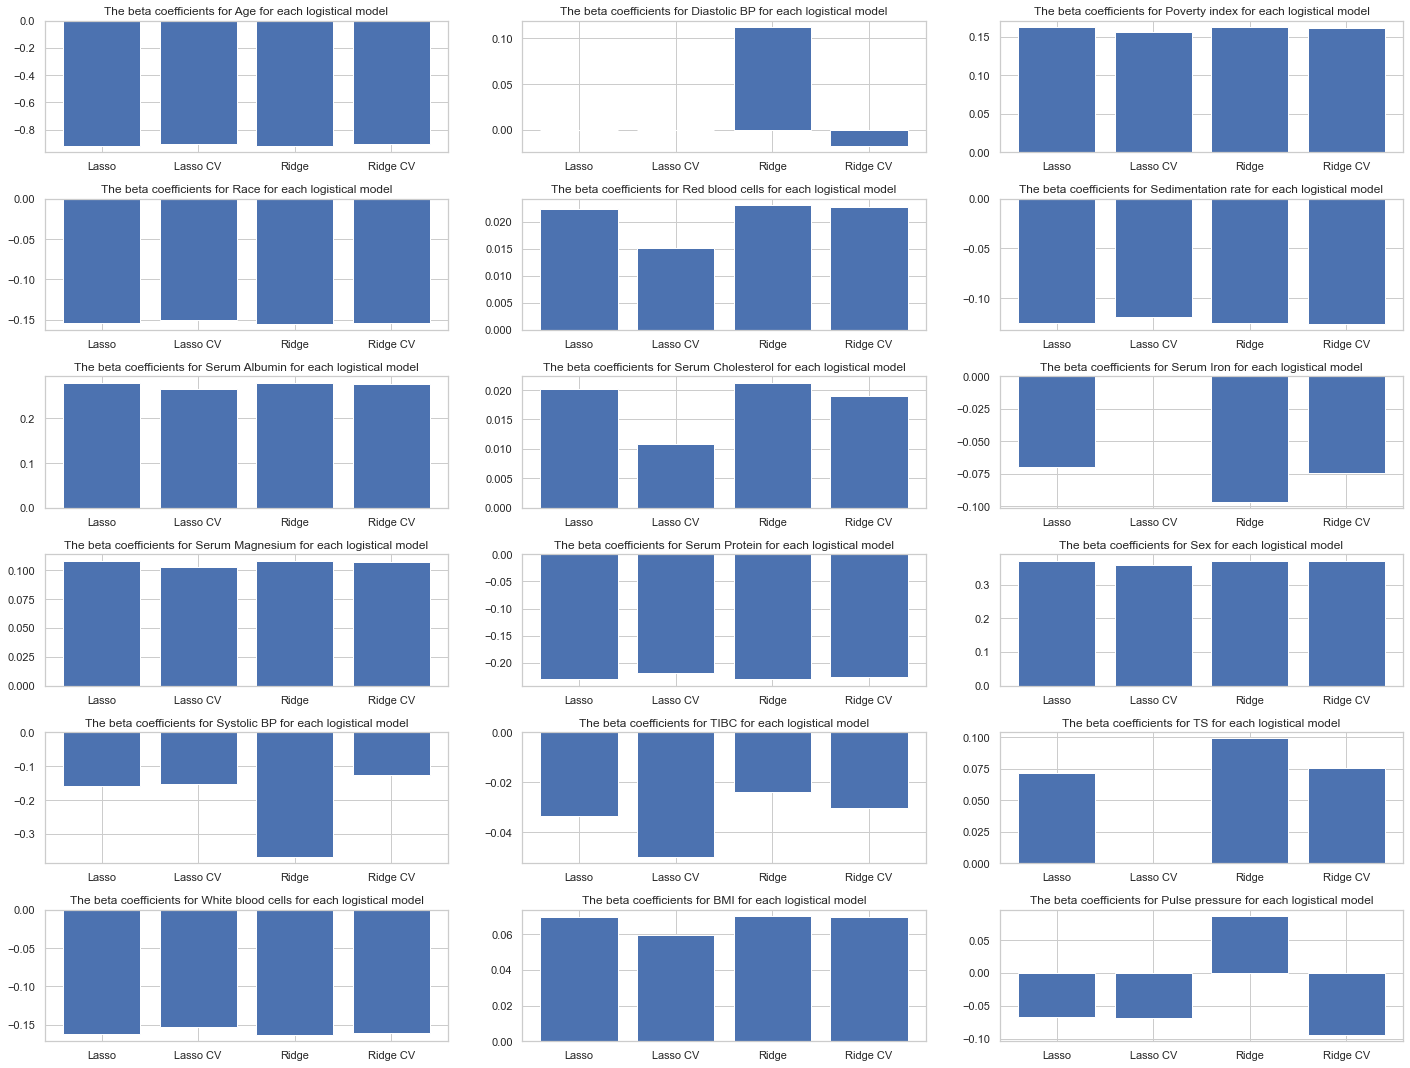

In [14]:
#Kernel density estimation for dropped predictors

fig, axes = plt.subplots(6, 3, figsize = (20, 15))
for i, col in enumerate(X_train_impute.columns):

    axes[i//3, i % 3].bar(x=labels, height = beta_coeff_dictionaries[col])
    #axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_one][col], label="Survived at least 18 years", alpha=0.4)
    axes[i//3, i % 3].set_label(col)
    axes[i//3, i % 3].set_title("The beta coefficients for " + col +" for each logistical model")
plt.tight_layout()


plt.show()
plt.clf()
plt.close()

Across the 4 variations of logisitic models, we see certain broad trends. Notably the regularized along with regularized and cross validated models all have similar accuracies to the base model of an unregularized logistic regression model. This suggests that regularization is not particularly significant for our dataset. However, when looking at individual beta coefficients, we can see broader trends. For instance the following predictors have a positive relationship with the log odds of surviving at least 18 years: Poverty Index, Red blood cell count, Serum Albumin, Serum Cholesterol, Serum Magnesium, Being Female, TS, and BMI. Meanwhile the following predictors have a negative relationship with the log odds of surviving at least 18 years: Age, being a racial minority, Sedimentation rate, Serum Iron, Serum Protein, Systolic BP, TIBC, White blood cells, and pulse pressure. 

Broadly speaking, the predictors have the highest magnitude / are most influential include: Age, Sex, and Serum Albumin. However, across the different models there still exist differences. Notably for the Diastolic BP predictor, the Lasso regularzied models suggest that there is no relation between Diastolic BP and log odds of survival, yet the Ridge models suggest otherwise. Nonetheless, the accuracy across these regularization models are comparable.

### <div class='exercise'> Single Decision Tree (CV) Performance </div>
---

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    cv_score_tracker = {}
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring="roc_auc")
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        cv_score_tracker[depth] = scores.mean()
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores, cv_score_tracker

cvmeans, cvstds, train_scores, scores_dict = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


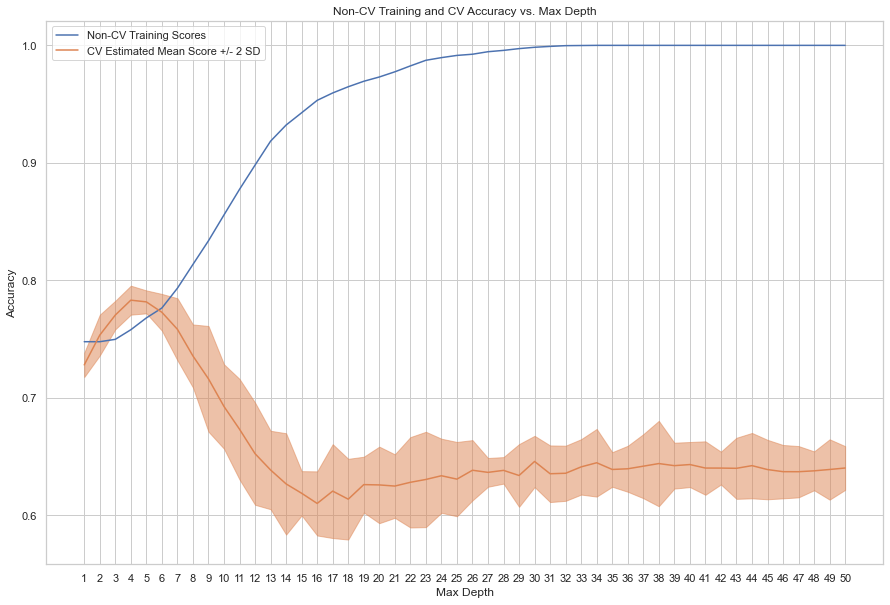

In [16]:
plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean Score +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Accuracy vs. Max Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);
plt.savefig("Single_Tree_Plots/Tree CV Training", bbox_inches = "tight")

In [17]:
best_depth = max(scores_dict, key=scores_dict.get)
dtree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_impute, y_train.values.ravel())
best_cv_tree_train_score = dtree.score(X_train_impute, y_train.values.ravel())
best_cv_tree_test_score = dtree.score(X_test_impute, y_test.values.ravel())
print(f"Best CV Tree Train Score: {best_cv_tree_train_score}")
print(f"Best CV Tree Test Score: {best_cv_tree_test_score}")
print(f"Best Depth: {best_depth}")
                                        

Best CV Tree Train Score: 0.7578351164254248
Best CV Tree Test Score: 0.7408152994464016
Best Depth: 4


<Figure size 432x288 with 0 Axes>

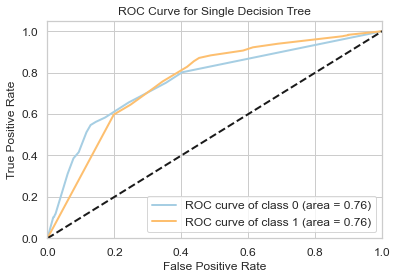

In [18]:
fig = plt.figure();
y_probas = dtree.predict_proba(X_test_impute);
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False, plot_macro=False, cmap="Paired");
plt.title("ROC Curve for Single Decision Tree");
plt.savefig("Single_Tree_Plots/ROC Curve Single Decision Tree", bbox_inches = "tight")
plt.show();

### <div class='exercise'> Single Decision Tree Interpretation </div>

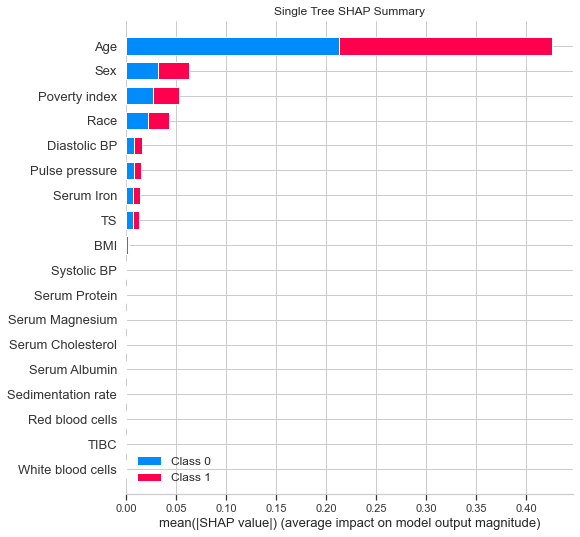

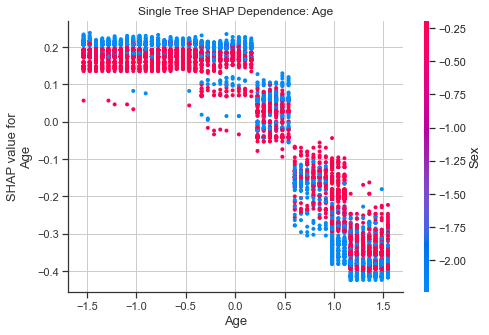

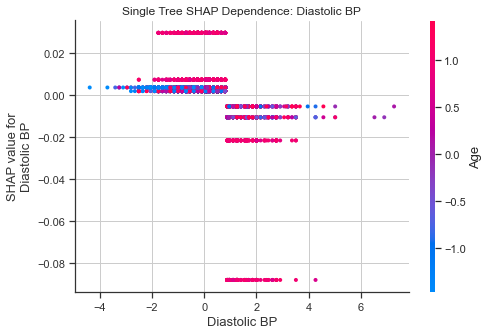

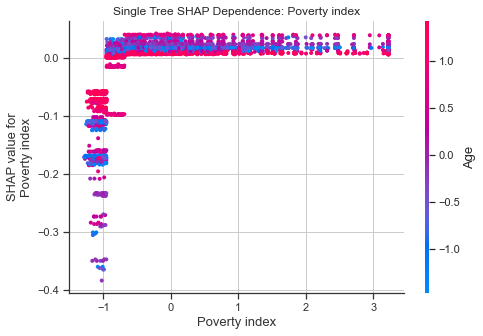

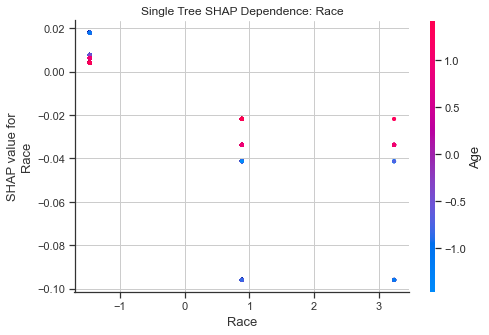

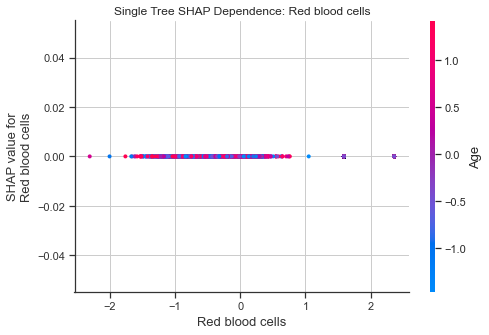

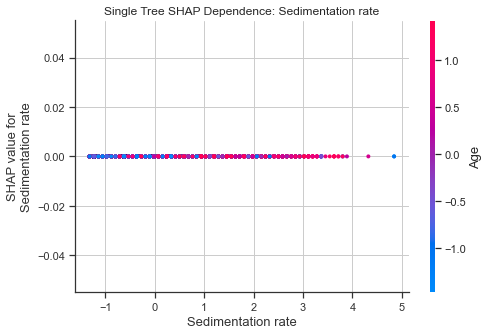

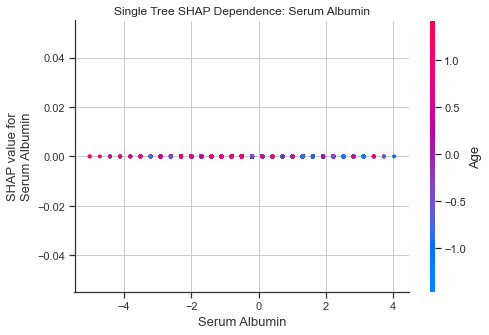

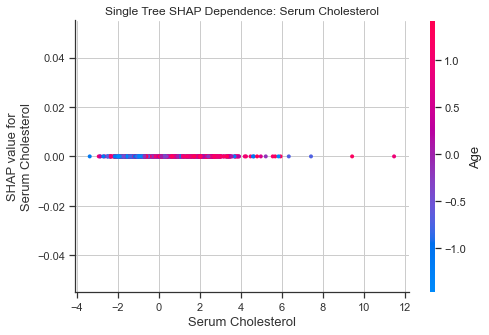

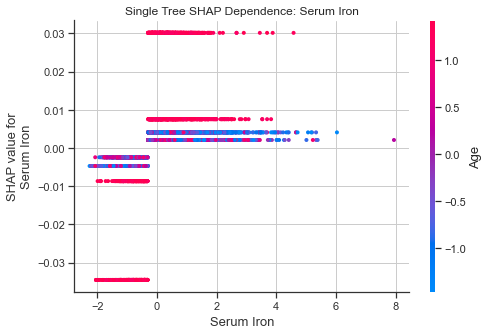

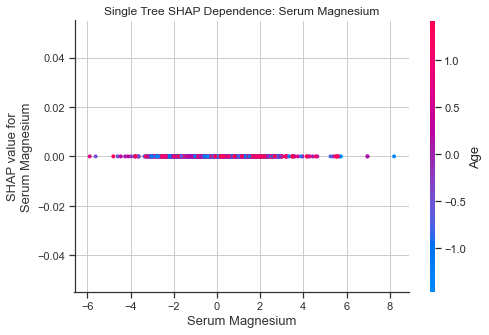

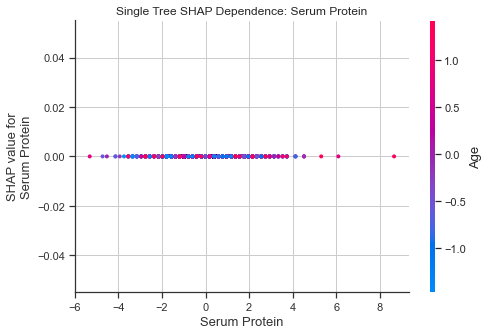

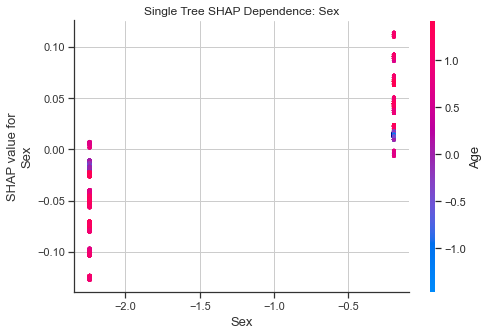

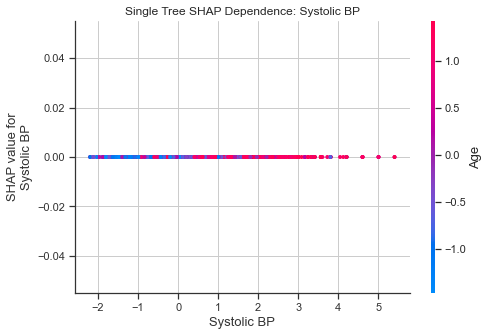

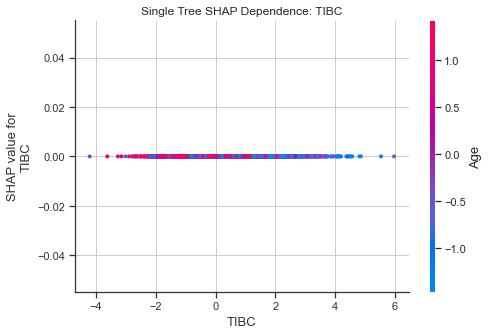

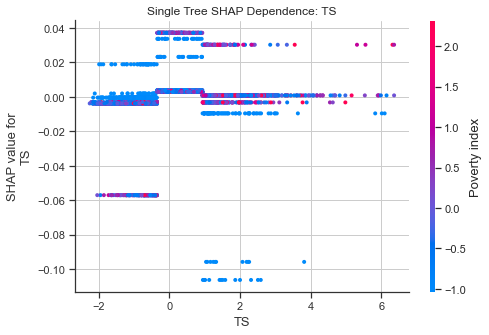

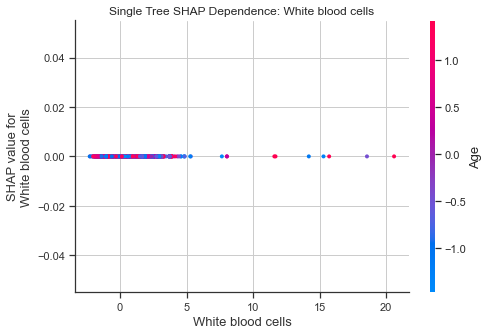

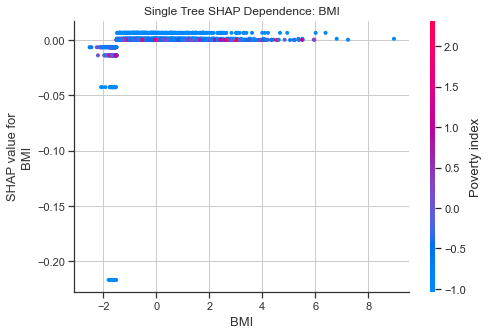

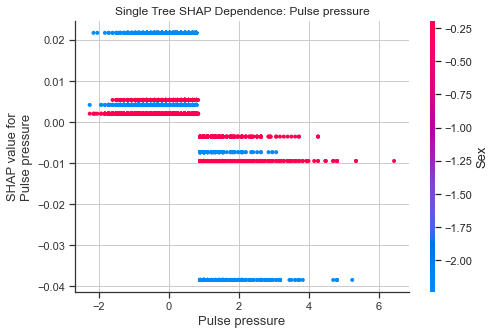

In [19]:
shap_values = shap.TreeExplainer(dtree).shap_values(X_train_impute)
shap.summary_plot(shap_values, X_train_impute, plot_type="bar", show=False)
plt.title("Single Tree SHAP Summary")
plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Summary", bbox_inches = "tight");

for i in range(18):
    shap.dependence_plot(X_train.columns[i], shap_values[1], X_train_impute, show=False);
    plt.title(f"Single Tree SHAP Dependence: {X_train.columns[i]}")
    plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Dependence_{X_train.columns[i]}", bbox_inches = "tight");
    

### <div class='exercise'> Decision Trees with Bagging </div>
---

In [20]:
param_grid = {'base_estimator__max_depth' : range(1,11), 
              'n_estimators' : [1,2,3,4,5,10,20,50,100]}

bagging_grid = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                                              param_grid, scoring = "roc_auc",verbose=1)

bagging_grid.fit(X_train_impute, y_train.values.ravel())
bagging_grid_best = bagging_grid.best_estimator_
bagging_best_params = bagging_grid.best_params_

y_pred_train = bagging_grid_best.predict(X_train_impute)
y_pred_test = bagging_grid_best.predict(X_test_impute)
bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)
print(f"Best Grid Search Bagging Model Score on Train: {bagging_model_train_accuracy}")
print(f"Best Grid Search Bagging Model Score on Test: {bagging_model_test_accuracy}")
print(f"Best Hyperparameters: {bagging_best_params}")


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  3.3min finished


Best Grid Search Bagging Model Score on Train: 0.7890892799241283
Best Grid Search Bagging Model Score on Test: 0.7247529702075157
Best Hyperparameters: {'base_estimator__max_depth': 7, 'n_estimators': 100}


<Figure size 432x288 with 0 Axes>

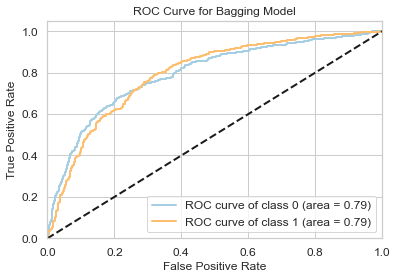

In [21]:
fig = plt.figure();
y_probas = bagging_grid_best.predict_proba(X_test_impute);
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False, plot_macro=False, cmap="Paired");
plt.title("ROC Curve for Bagging Model");
plt.savefig("Bagging/Bagging ROC Curve", bbox_inches = "tight")
plt.show();

### <div class='exercise'> Bagging Model Interpretation </div>

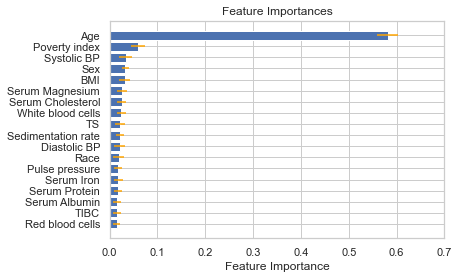

In [22]:
importances = np.mean([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
indices = np.argsort(importances)

features = X_train_impute.columns
plt.barh(range(len(indices)), importances[indices], color='b', 
         xerr=std[indices], align='center', ecolor='orange')
plt.title('Feature Importances')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.xlim(0, 0.7)
plt.savefig(f"Bagging/Bagging Feature_importances", bbox_inches = "tight");
plt.show()

In [23]:
r = permutation_importance(bagging_grid_best, X_test_impute, y_test.values.ravel(), n_repeats=15)                           

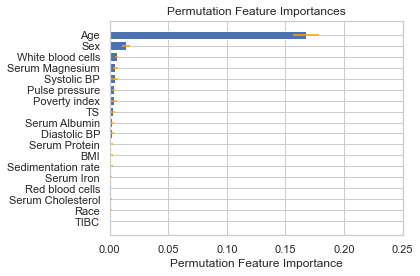

In [24]:
indices = np.argsort(r.importances_mean)
std = r.importances_std

fig = plt.figure()
plt.barh(range(len(indices)), r.importances_mean[indices], color='b', 
         align='center', xerr=std[indices], ecolor="orange")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Permutation Feature Importances')
plt.xlabel('Permutation Feature Importance')
plt.xlim(0, 0.25)
fig.tight_layout()
plt.savefig(f"Bagging/Bagging Permuation_importances", bbox_inches = "tight");
plt.show()


### <div class="exercise"> Boosting </div>

Text(0, 0.5, 'staged score')

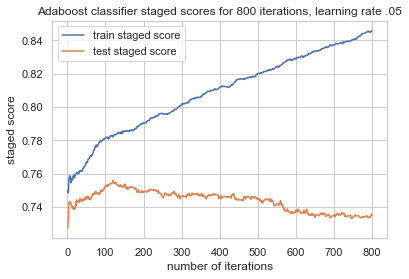

In [25]:
# Boosting - Vineet
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=800)
boost.fit(X_train_impute, y_train.values.ravel())

boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

plt.plot(range(1,801), boost_train_staged_score, label = "train staged score")
plt.plot(range(1,801), boost_test_staged_score, label = "test staged score")
plt.title("Adaboost classifier staged scores for 800 iterations, learning rate .05")
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("staged score")

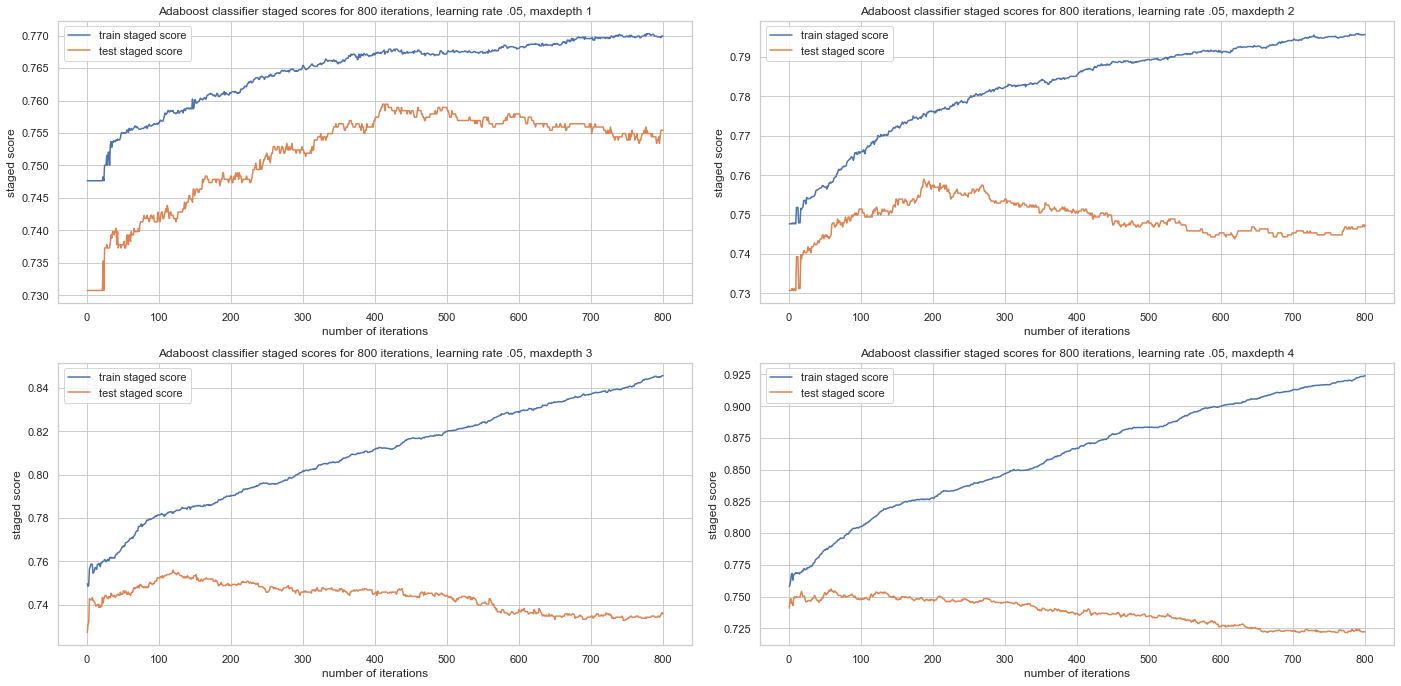

In [26]:
depths = [1,2,3,4]
fig, axs = plt.subplots(2,2, figsize=(20,10))

fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i in range(len(depths)):
    boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depths[i]), learning_rate=0.05, n_estimators=800)
    boost.fit(X_train_impute,y_train.values.ravel())

    boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
    boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

    axs[i].plot(range(1,801), boost_train_staged_score, label = "train staged score")
    axs[i].plot(range(1,801), boost_test_staged_score, label = "test staged score")
    axs[i].set_title("Adaboost classifier staged scores for 800 iterations, learning rate .05, maxdepth " + str(depths[i]))
    axs[i].legend()
    axs[i].set_xlabel("number of iterations")
    axs[i].set_ylabel("staged score")


In [27]:
boost_depth3 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=120)
boost_depth3.fit(X_train_impute,y_train.values.ravel())

y_train_pred = boost_depth3.predict(X_train_impute)
boost_depth3_train_score = roc_auc_score(y_train_pred, y_train)
y_test_pred = boost_depth3.predict(X_test_impute)
boost_depth3_test_score = roc_auc_score(y_test_pred, y_test)

boost_depth3_train_score, boost_depth3_test_score

(0.7758099486959549, 0.7469545881759623)

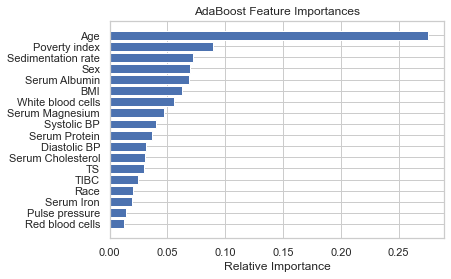

In [28]:
features = X_train.columns
importances = boost_depth3.feature_importances_
indices = np.argsort(importances)

plt.title("AdaBoost Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [29]:
from sklearn.inspection import permutation_importance
features = X_train.columns
importances = permutation_importance(boost_depth3, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

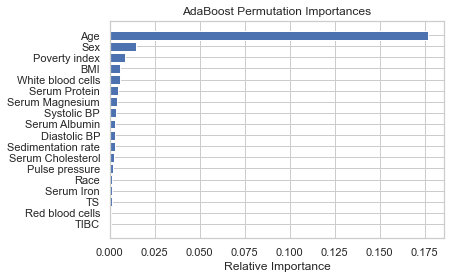

In [30]:
plt.title("AdaBoost Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [33]:
import xgboost
#xgb_train = xgboost.DMatrix(X_train_impute, label=y_train)
#xgb_test = xgboost.DMatrix(X_test_impute, label=y_test)

xgboost_full = xgboost.XGBClassifier(n_estimators=120, use_label_encoder=False, learning_rate=0.05, max_depth=3, eval_metric='error').fit(X_train_impute, y_train.values.ravel())

In [34]:
# see how well we can order people by survival
y_test_pred = xgboost_full.predict(X_test_impute, ntree_limit=5000)
print(roc_auc_score(y_test_pred, y_test))

0.747091041003235


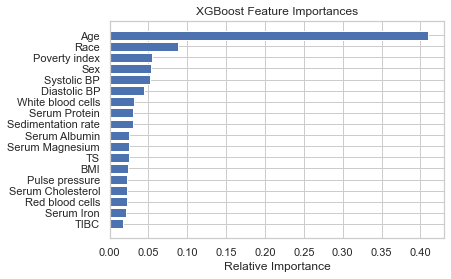

In [35]:
features = X_train.columns
importances = xgboost_full.feature_importances_
indices = np.argsort(importances)

plt.title("XGBoost Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [36]:
features = X_train.columns
importances = permutation_importance(xgboost_full, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

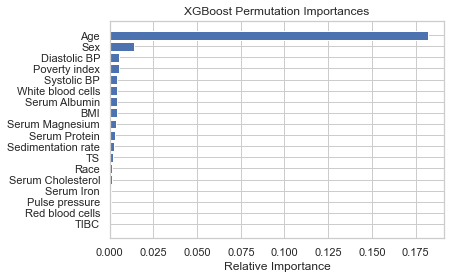

In [37]:
plt.title("XGBoost Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

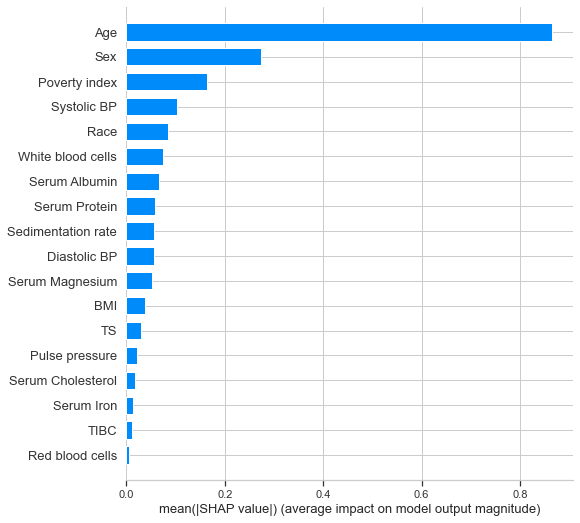

In [38]:
import shap
X_train_impute_shap = pd.DataFrame(X_train_impute, columns = X_train.columns)
X_test_impute_shap = pd.DataFrame(X_test_impute, columns = X_train.columns)
shap_values_xgboost = shap.TreeExplainer(xgboost_full).shap_values(X_train_impute_shap)
shap.summary_plot(shap_values_xgboost, X_train_impute_shap, plot_type="bar", alpha=0.5)

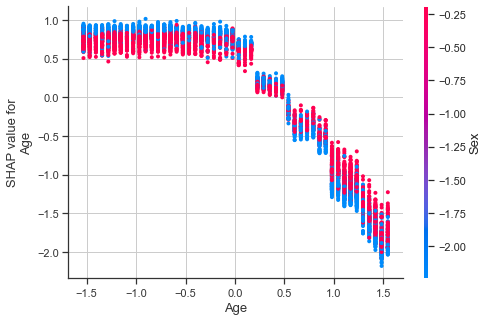

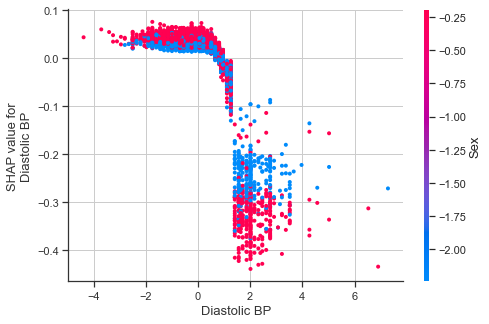

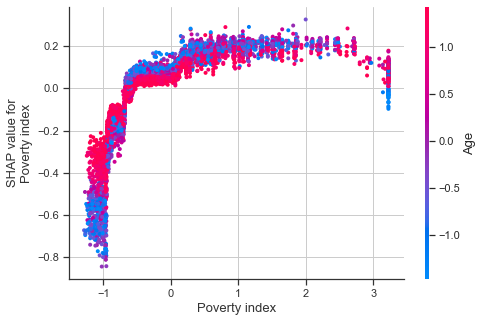

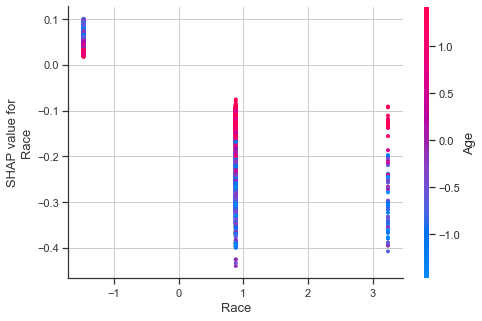

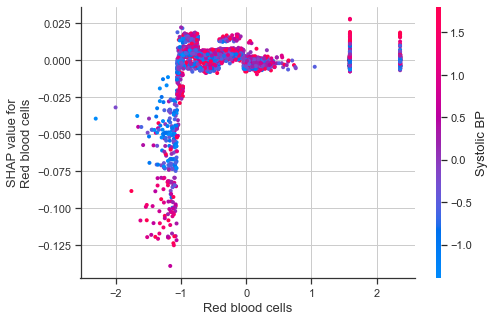

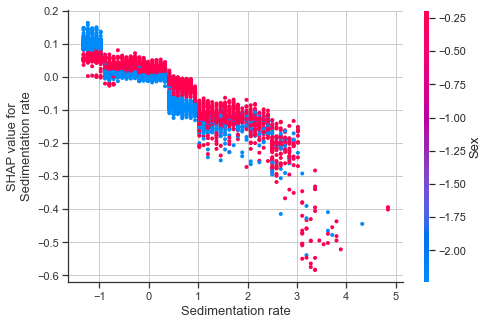

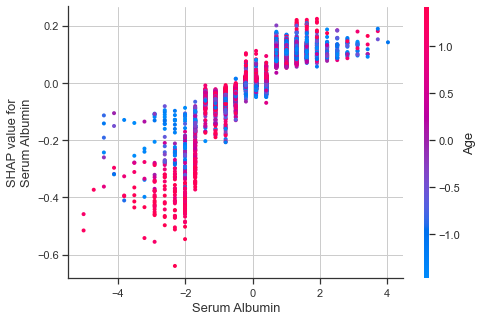

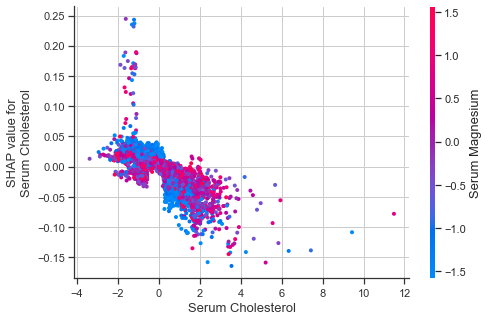

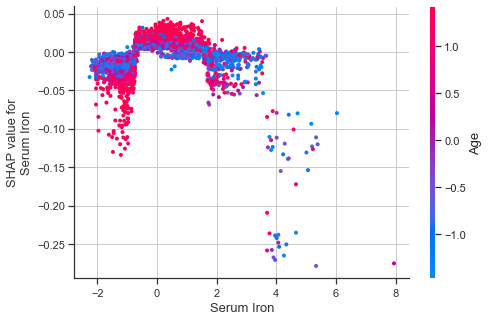

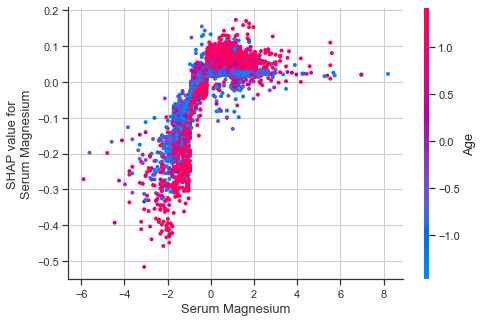

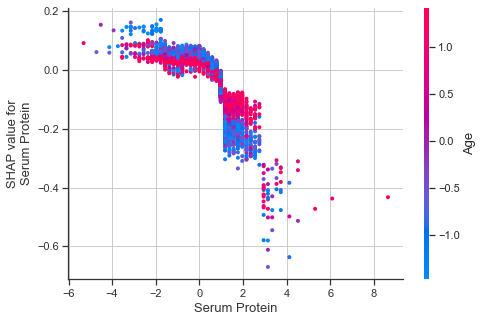

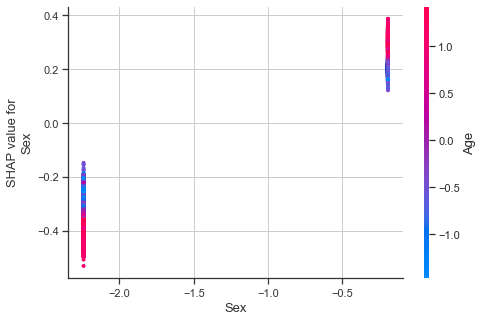

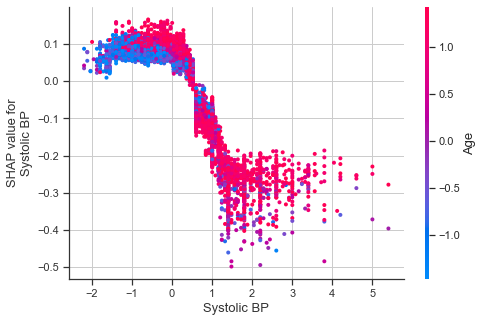

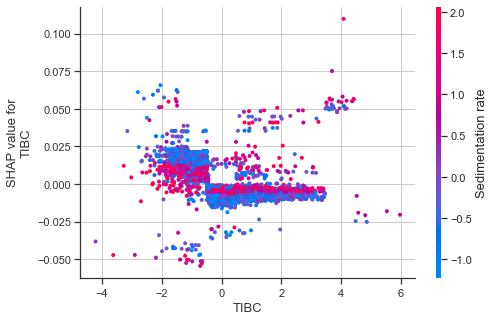

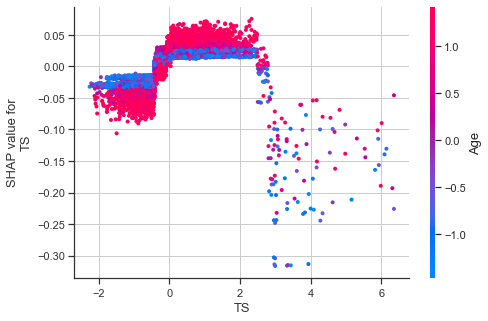

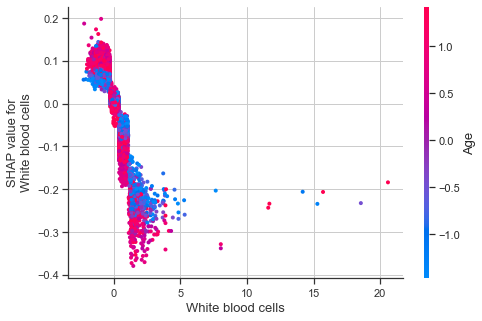

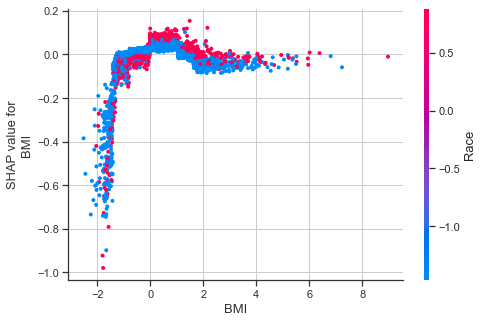

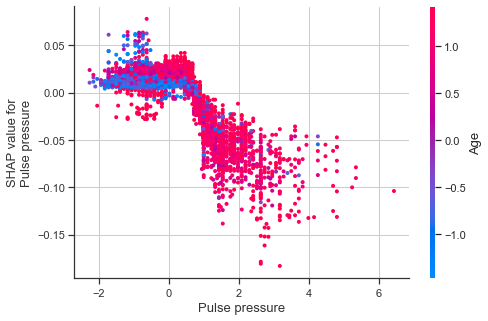

In [39]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values_xgboost, X_train_impute_shap)

In [40]:
# the top 4 are Age, Sex, Poverty Index, and Systolic BP
top4 = ['Age', 'Sex', "Poverty index", 'Systolic BP']
xgboost_top4 = xgboost.XGBClassifier(n_estimators=150, use_label_encoder=False, learning_rate=0.05, max_depth=4,eval_metric='error').fit(X_train_impute_shap[top4], y_train.values.ravel())

y_test_pred = xgboost_top4.predict(X_test_impute_shap[top4], ntree_limit=5000)
print(roc_auc_score(y_test_pred, y_test))

0.7388956223327435


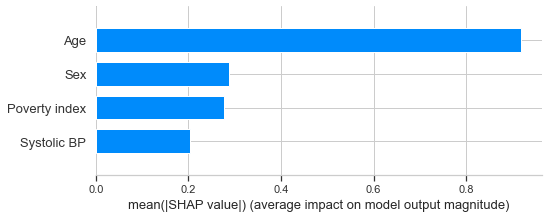

In [41]:
shap_values_xgboost = shap.TreeExplainer(xgboost_top4).shap_values(X_train_impute_shap[top4])
shap.summary_plot(shap_values_xgboost, X_train_impute_shap[top4], plot_type="bar", alpha=0.5)

In [42]:
# remove Age
X_train_impute_no_age = X_train_impute_shap.drop("Age", axis=1)
X_test_impute_no_age = X_test_impute_shap.drop("Age", axis=1)
xgboost_no_age = xgboost.XGBClassifier(n_estimators=120, use_label_encoder=False, learning_rate=0.05, max_depth=3, eval_metric='error').fit(X_train_impute_no_age, y_train.values.ravel())

y_test_pred = xgboost_no_age.predict(X_test_impute_no_age, ntree_limit=5000)
print(roc_auc_score(y_test_pred, y_test))

0.6902531516321524


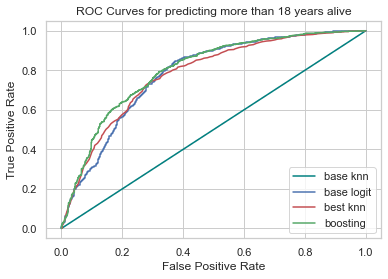

In [43]:
yhat_knn= best_knn.predict_proba(X_test_impute)[:,1]
yhat_baseknn= baseline_kNN_model.predict_proba(X_test_impute)[:,1]
yhat_logit= logit_base.predict_proba(X_test_impute)[:,1]
yhat_xgboost= xgboost_full.predict_proba(X_test_impute)[:,1]
#yhat_rf= rf.predict_proba(X_test_impute)[:,1]

# gets fpr and tpr rates
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, yhat_knn)
fpr_baseknn, tpr_baseknn, thresholds_baseknn = roc_curve(y_test, yhat_baseknn)
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, yhat_logit)
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, yhat_xgboost)
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, yhat_rf)

# ROC curve plot
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_baseknn,tpr_baseknn,label="base knn", c='teal')
plt.plot(fpr_logit,tpr_logit,label="base logit",c='b')
plt.plot(fpr_knn,tpr_knn,label="best knn", c='r')
plt.plot(fpr_boost,tpr_boost,label="boosting", c='g')
#plt.plot(fpr_rf,tpr_rf,label="random forest", c='black')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curves for predicting more than 18 years alive")
plt.legend(loc='lower right')
plt.show()

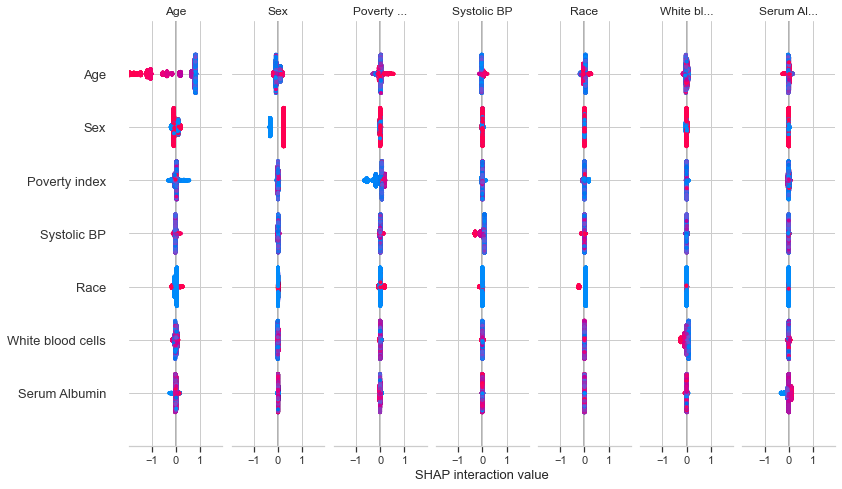

In [45]:
shap_interaction_values = shap.TreeExplainer(xgboost_full).shap_interaction_values(X_train_impute_shap)
shap.summary_plot(shap_interaction_values, X_train_impute_shap)

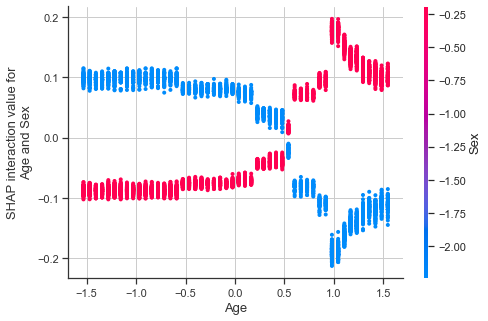

In [46]:
shap.dependence_plot( ("Age", "Sex"),shap_interaction_values, X_train_impute_shap,)

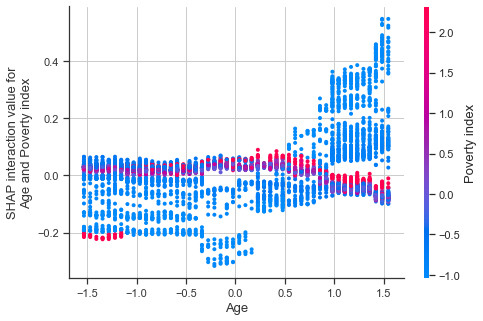

In [47]:
shap.dependence_plot( ("Age", "Poverty index"),shap_interaction_values, X_train_impute_shap,)

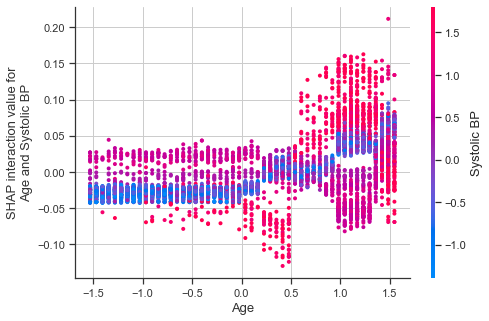

In [48]:
shap.dependence_plot( ("Age", "Systolic BP"),shap_interaction_values, X_train_impute_shap,)

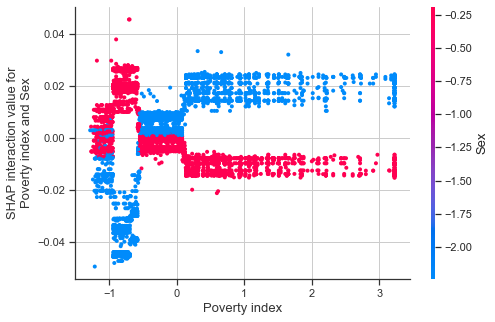

In [49]:
shap.dependence_plot( ("Poverty index","Sex"),shap_interaction_values, X_train_impute_shap,)

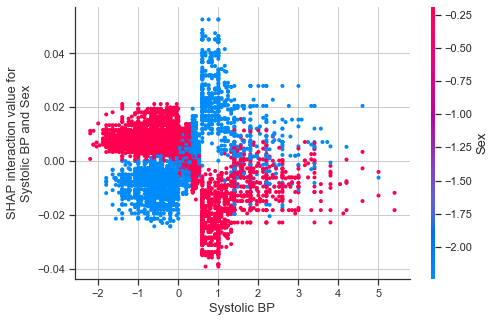

In [50]:
shap.dependence_plot( ('Systolic BP',"Sex"),shap_interaction_values, X_train_impute_shap,)

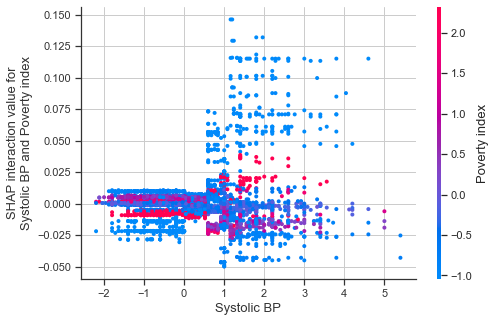

In [51]:
shap.dependence_plot( ('Systolic BP',"Poverty index"),shap_interaction_values, X_train_impute_shap,)

## Random Forest

In [52]:
## Random Forest - Sean
## grid search with 5-fold cross-validation
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

#hyperF = dict(n_estimators = [500], max_depth = [5, 8, 15, 25, 35],
#             min_samples_split = [2, 5, 10, 15, 50])
#gridF = GridSearchCV(RandomForestClassifier(random_state = 69), hyperF, cv = 5, verbose = 1, n_jobs = -1)
#bestF = gridF.fit(X_train_impute, y_train.values.ravel())
#bestF.best_estimator_

# should get min_samples_split = 50, max_depth = 15, min_samples_leaf default?


In [53]:
from sklearn.ensemble import RandomForestClassifier

# fit the random forest with extracted hyperparameters
rf = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_split = 15, random_state = 69)
rf.fit(X_train_impute, y_train.values.ravel())

# test accuracy
y_pred = rf.predict(X_test_impute)
rf_test_accuracy = roc_auc_score(y_test, y_pred)


In [54]:
print(f"random forest test accuracy is {rf_test_accuracy}")

random forest test accuracy is 0.7312890221981131


In [ ]:
shap_values_dtree = shap.TreeExplainer(rf).shap_values(X_train_impute)
shap.summary_plot(shap_values_dtree, X_train_impute, plot_type="bar", alpha=0.5)


In [ ]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title("Random Forest Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
### Inlcude permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_train_impute, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance for random forest")

# Interpretation

In all three metrics, age was deemed the most important and is deemed much more important than the other predictors. The importance plots have similar rankings for the predictors, so they roughly agree on their relative importances. Beyond the most important the importances start to disagree. However, the predictors sex, systolic bp, poverty index, and pulse pressure are close to the top for most of our metrics, which suggests that these predictors are big contributors to the model and the response. 